<a href="https://colab.research.google.com/github/anassboussarhan/satellitesegmentation/blob/master/UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras.applications import vgg16, inception_v3, resnet50, mobilenet
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

#Load the VGG model
vgg_model = vgg16.VGG16(weights='imagenet')



from google.colab import drive
drive.mount('/content/drive/')

Using TensorFlow backend.


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:

from __future__ import print_function
import numpy as np
import tensorflow as tf
import random as rn
import os
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
rn.seed(12345)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [0]:
import glob
from keras.preprocessing import image as kImage
from keras.preprocessing.image import array_to_img, img_to_array, load_img

def getData(dataset_dir):
    X_list= sorted(glob.glob(os.path.join(dataset_dir, 'images/','*.png')))
    Y_list = sorted(glob.glob(os.path.join(dataset_dir, 'labels/' ,'*.png')))
    
    X= []
    Y= []
  
    
    gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         zoom_range = 0.3,
                         rotation_range = 40)

    
    
    
    for i in range(len(X_list)):
        # Load input image
        x = kImage.load_img(X_list[i])
        x = kImage.img_to_array(x)
        X.append(x)
        y = kImage.load_img(Y_list[i], grayscale = True)
        z = kImage.img_to_array(y)
        y = z/255.0
        y = np.floor(y)
        Y.append(y)
        genx=gen.flow(x,batch_size=25,seed=666 )
        geny=gen.flow(y,batch_size=25,seed=666)
        for i in range(24):
          x=genx.next()
          y=geny.next()
          x = kImage.load_img(x)
          x = kImage.img_to_array(x)
          X.append(x)
          y = kImage.load_img(y, grayscale = True)
          z = kImage.img_to_array(y)
          y = z/255.0
          y = np.floor(y)
        Y.append(y)
    
 
            
    X = np.asarray(X)
    Y = np.asarray(Y)
    # Shuffle the training data
    idx = list(range(X.shape[0]))
    np.random.shuffle(idx)
    X = X[idx]
    Y = Y[idx]
    return X, Y
  
def gentest(dataset_dir):
    X_list= sorted(glob.glob(os.path.join(dataset_dir, 'images/','*.png')))
    Y_list = sorted(glob.glob(os.path.join(dataset_dir, 'labels/' ,'*.png')))
    
    X= []
    Y= []
    for i in range(len(X_list)):
        # Load input image
        x = kImage.load_img(X_list[i])
        x = kImage.img_to_array(x)
        X.append(x)
        y = kImage.load_img(Y_list[i], grayscale = True)
        z = kImage.img_to_array(y)
        y = z/255.0
        y = np.floor(y)
        Y.append(y)
         
    X = np.asarray(X)
    Y = np.asarray(Y)
    # Shuffle the training data
    idx = list(range(X.shape[0]))
    np.random.shuffle(idx)
    X = X[idx]
    Y = Y[idx]
    return X, Y

In [0]:

import keras
from keras.models import Model
from keras.layers import Deconv2D, Input
from keras import backend as k

def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

def initModel():
    ### Encoder
    net_input = Input(shape=(256,256,3))
    vgg16 = keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=net_input)
    for layer in vgg16.layers[:17]:
      layer.trainable = False
    
    x = vgg16.layers[-2].output # 2nd layer from the last, block5_conv3
    
    ### Decoder
    x = Deconv2D(256, (3,3), strides=(2,2), activation='relu', padding='same')(x)
    x = Deconv2D(128, (3,3), strides=(2,2), activation='relu', padding='same')(x)
    x = Deconv2D(64, (3,3), strides=(2,2), activation='relu', padding='same')(x)
    x = Deconv2D(32, (3,3), strides=(2,2), activation='relu', padding='same')(x)
    x = Deconv2D(1, (1,1), activation='sigmoid', padding='same')(x)
    
    model = Model(inputs=vgg16.input, outputs=x)
    model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.RMSprop(lr=5e-4), metrics=["accuracy"])
    return model

In [0]:
dataset_path = os.path.join('/content/drive/My Drive/projet2/', 'train/')
X, Y = getData(dataset_path)

# init the model
model = initModel()

early = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10)
reduce = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

model.fit(X, Y, batch_size=1, epochs=40, verbose=2, validation_split=0, callbacks=[reduce, early], shuffle=True)
model.save('my_model.h5')
print("saved")

ValueError: ignored

In [0]:
# load test data
dataset_path = os.path.join('/content/drive/My Drive/projet2/', 'test/')
X, Y = gentest(dataset_path)
# predict
pred = model.predict(X, verbose=1, batch_size=1)
print(tf.Session().run(K.mean(K.equal(Y, K.round(pred)))))
# output: test on GPU
# 10/10 [==============================] - 1s 68ms/step
# 0.98944664

5/5 [==============================] - 1s 200ms/step
0.8020996


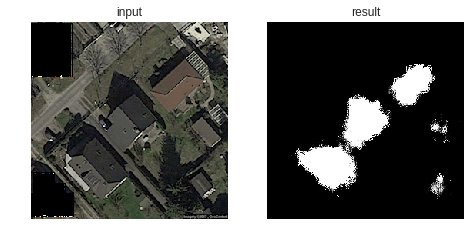

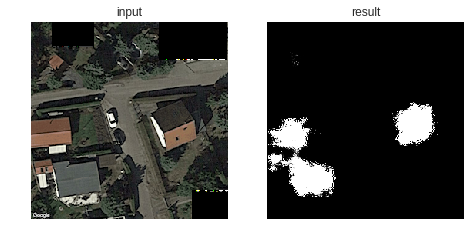

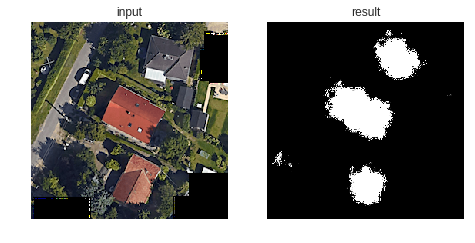

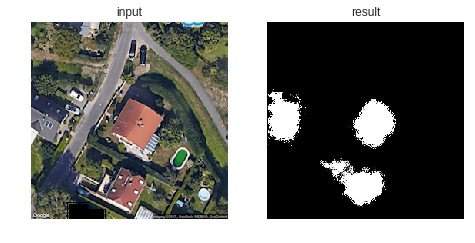

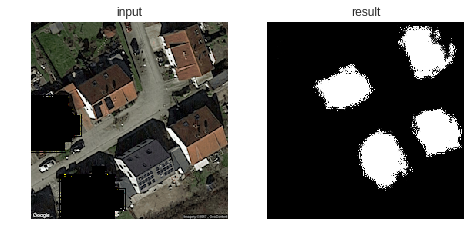

In [0]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12.0, 9.0)

idx = 1 # image index that you want to display
for j in range(5):
  img = np.empty(3, dtype=object)
  img[0] = X[j-1]
  img[1] = pred[j-1].reshape(pred[j-1].shape[0],pred[j-1].shape[1])
  title = ['input', 'result']
  for i in range(2):
    plt.subplot(1, 3, i+1)
    if i==0:
      plt.imshow(img[i].astype('uint8'))
    else:
      plt.imshow(img[i], cmap='gray')
  
    plt.axis('off')
    plt.title(title[i])
  plt.show()